## Классификация комментариев для «Викишоп» с BERT

**Содержание**
1. [Подготовка](https://colab.research.google.com/drive/1pFHtAdvWrEJyPjagbsZgKr_GeU52hmbG#scrollTo=wzZMlBSc-riH&line=1&uniqifier=1)
2. [Обучение](https://colab.research.google.com/drive/1pFHtAdvWrEJyPjagbsZgKr_GeU52hmbG#scrollTo=Lc9enLwsz-rZ&line=1&uniqifier=1)
3. [Тестирование](https://colab.research.google.com/drive/1pFHtAdvWrEJyPjagbsZgKr_GeU52hmbG#scrollTo=LVbAFBAz964N&line=1&uniqifier=1)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

**Инструкция по выполнению проекта**

Загрузите и подготовьте данные.
Обучите разные модели.
Сделайте выводы.
Для выполнения проекта применять BERT необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## 1 Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tqdm import notebook
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle # для перемешивания данных
import time

In [2]:
pd.options.display.max_colwidth = 500 # выведем побольше символов в ячейках

In [3]:
df = pd.read_csv('./toxic_comments.csv')
df.head(20)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Приведем алгоритм проведения классификации с помощью Embeddings:

1. Проводится предобработка текста:
2. Выполняется токенизация каждого текста, то есть его разбивают на слова;
3. Проводится лемматизация, если используется не BERT;
4. Текст очищается от стоп-слов и ненужных символов;
5. Для корректной работы алгоритма добавляют маркеры начала и конца предложения (они приравниваются к токенам).
6. На выходе у каждого исходного текста образуется свой список токенов.
7. Токены передают модели, которая переводит их в векторные представления. Для этого модель обращается к составленному заранее словарю токенов. На выходе для каждого текста образуются векторы заданной длины.
8. На финальном этапе модели передают признаки (векторы). И она прогнозирует эмоциональную окраску текста — 0 («отрицательная») или 1 («положительная»).

Начнем с предобработки текста. Оставим только слова, состоящие из букв.

In [4]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

In [5]:
df['text'] = df['text'].apply(clear_text)

Приведем текст к нижнему регистру.

In [6]:
df['text'] = df['text'].str.lower()
df.head()

,text,toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay u...,0
4,you sir are my hero any chance you remember what page that s on,0


In [7]:
df.duplicated().sum()

1293

Избавимся от дубликатов.

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Исследуем соотношение классов.

0   0.898
1   0.102
Name: toxic, dtype: float64


<AxesSubplot:>

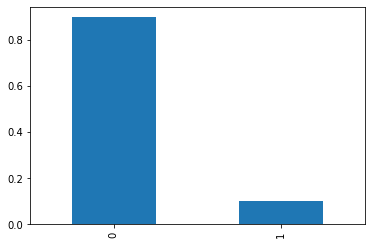

In [9]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Гистограмма показала, что классы не сбалансированы. После подготовки эмбеддингов необходимо будет провести ликвидацию дисбаланса.

Т.к. выданный заказчиком датасет достаточно велик, для создания его ембеддингов понадобятся значительные вычислительные мощности. В виду отсутствия данных мощностей, выберем 17000 случайных строк для выполнения проекта с сохранением исходного дисбаланса классов. Чтобы сохранить выявленный дисбаланс классов, применим метод train_test_split.

Лемматизация текста

In [10]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(x))]))

In [12]:
df_rest, df_1 = train_test_split(df, test_size=17000, random_state=12345)
df_1.shape

(17000, 2)

Проведем токенизацию текстов.

In [13]:
def make_embeddings(features):
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

    # Загрузка предобученной модели/токенизатора 
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    tokenized= features.apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    batch_size = 100

    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

    final_features = np.concatenate(embeddings)
    final_features = pd.DataFrame(final_features)
    return final_features

In [14]:
#!c1.8
features = make_embeddings(df_1['text'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
target = df_1['toxic'].reset_index(drop=True)

In [16]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
features, target, test_size=0.4, stratify=target, random_state=12345) # разделили выборки в пропорции 4 к 10

features_test, features_valid, target_test, target_valid = train_test_split(
features_valid_test, target_valid_test, test_size=0.5, stratify=target_valid_test, random_state=12345) # разделили вал-ую и тестовую пополам

In [17]:
print(features_train.shape)
print(features_test.shape)

(10200, 768)
(3400, 768)


In [18]:
target_train.value_counts()

0    9203
1     997
Name: toxic, dtype: int64

In [19]:
features_train.shape

(10200, 768)

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [21]:
repeat=10
features_train, target_train = upsample(features_train, target_train, repeat)
print(features_train.shape)
print(target_train.value_counts())

(19173, 768)
1    9970
0    9203
Name: toxic, dtype: int64


Данные подготовлены, переходим к обучению моделей.

## 2 Обучение моделей

Логистическая регрессия

In [22]:
%%time
best_model = None
best_result = 0
best_с = 0
for reg in np.linspace(0.0001, 100, 20):
    model = LogisticRegression(random_state=12345, solver='liblinear', C=reg)
    model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    result = f1_score(target_valid, predictions) # посчитаем качество модели
    print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_с = reg
print('Наилучшее качество модели {:.3f} при регуляризации {}'.format(best_result, best_с))

0.4620303756994405
0.6328217237308147
0.6278240190249702
0.6229116945107399
0.6281588447653429
0.6258992805755396
0.6274038461538461
0.6265060240963856
0.6280193236714976
0.6272617611580217
0.6265060240963856
0.6233453670276775
0.6233453670276775
0.6216867469879517
0.6200241254523523
0.6200241254523523
0.6200241254523523
0.619105199516324
0.6198547215496368
0.6207729468599035
Наилучшее качество модели 0.633 при регуляризации 5.263252631578947
CPU times: user 14min 27s, sys: 9.45 s, total: 14min 36s
Wall time: 14min 31s


Случайный лес

In [23]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 101, 10):
    for depth in range (1, 9):
        for spl in (2, 7):
            model = RandomForestClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     max_depth=depth, min_samples_split = spl) # инициализируем модель
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = spl

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth,
     "Минимальное количество примеров для разделения", best_split)

0.43913713405238824
0.43913713405238824
0.5070921985815602
0.5070921985815602
0.5176252319109462
0.5176252319109462
0.5429417571569595
0.5429417571569595
0.5533678756476684
0.5533678756476684
0.574585635359116
0.5704772475027747
0.5992865636147443
0.5992865636147443
0.6377952755905513
0.6370757180156658
0.45687645687645695
0.45687645687645695
0.5053956834532375
0.5053956834532375
0.5284090909090908
0.5284090909090908
0.5470588235294118
0.5470588235294118
0.5666316894018887
0.5666316894018887
0.6039488966318234
0.6146682188591385
0.6131386861313868
0.6248462484624847
0.656675749318801
0.6452476572958501
0.4525096525096526
0.4525096525096526
0.5031333930170098
0.5031333930170098
0.5423076923076924
0.5423076923076924
0.5565388397246804
0.5565388397246804
0.5852631578947368
0.5852631578947368
0.6096997690531177
0.6080924855491329
0.6277915632754343
0.628992628992629
0.6538461538461539
0.6530612244897959
0.46869983948635635
0.46869983948635635
0.5145454545454545
0.5145454545454545
0.5369127

LightGBM

In [24]:
best_model = None
best_result = 0
best_est = 0
best_leaves = 0
best_rate = 0
for est in [50, 100, 500]:
    for leave in [21, 31, 41, 51]:
        for rate in [0.01, .04, 0.06, 0.3]:
            model = LGBMClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     num_leaves=leave, learning_rate = rate) # инициализируем модель
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_leaves = leave
                best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Скорость обучения:", best_rate,
     "Количество листьев", best_leaves)

0.5312800769971127
0.6150341685649203
0.6306954436450839
0.6706766917293233
0.5527123848515866
0.6284348864994026
0.6438529784537389
0.6838709677419356
0.564430244941427
0.6393034825870647
0.6648936170212766
0.6890756302521008
0.5860155382907881
0.6519480519480519
0.6629680998613037
0.6835016835016836
0.5777310924369748
0.641089108910891
0.6666666666666666
0.6753670473083198
0.6017699115044248
0.6421052631578947
0.6817538896746819
0.6757679180887372
0.6220657276995304
0.6592797783933518
0.6786248131539611
0.7001733102253033
0.6375757575757576
0.679245283018868
0.6791277258566977
0.6761565836298932
0.6486486486486487
0.6956521739130435
0.6923076923076923
0.6875
0.6766712141882673
0.6868686868686869
0.6850258175559379
0.6909722222222222
0.6754002911208151
0.6758147512864494
0.671353251318102
0.6938053097345134
0.6838124054462935
0.6747826086956522
0.6784452296819788
0.6844919786096257
F1 наилучшей модели на валидационной выборке: 0.7001733102253033 Количество деревьев: 100 Скорость обуче

CatBoost

In [25]:
best_model = None
best_result = 0
best_iter = 0
best_rate = 0
for iter in [150, 500]:
  for rate in [0.01, .04, 0.06, 0.3, 0.5]:
    model = CatBoostClassifier(random_state=12345, 
                                     iterations=iter, learning_rate = rate) # инициализируем модель
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
    print(result)
    if result > best_result:
      best_model = model
      best_result = result
      best_iter = iter
      best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество иттераций:", best_iter, "Скорость обучения:", best_rate)

0:	learn: 0.6856266	total: 206ms	remaining: 30.7s
1:	learn: 0.6782880	total: 324ms	remaining: 24s
2:	learn: 0.6710190	total: 449ms	remaining: 22s
3:	learn: 0.6640586	total: 566ms	remaining: 20.6s
4:	learn: 0.6568903	total: 687ms	remaining: 19.9s
5:	learn: 0.6486615	total: 806ms	remaining: 19.3s
6:	learn: 0.6418111	total: 929ms	remaining: 19s
7:	learn: 0.6351979	total: 1.05s	remaining: 18.7s
8:	learn: 0.6291044	total: 1.18s	remaining: 18.4s
9:	learn: 0.6231589	total: 1.3s	remaining: 18.2s
10:	learn: 0.6174885	total: 1.42s	remaining: 18s
11:	learn: 0.6119111	total: 1.54s	remaining: 17.7s
12:	learn: 0.6060488	total: 1.66s	remaining: 17.5s
13:	learn: 0.6001474	total: 1.78s	remaining: 17.3s
14:	learn: 0.5949582	total: 1.9s	remaining: 17.1s
15:	learn: 0.5890932	total: 2.02s	remaining: 16.9s
16:	learn: 0.5842923	total: 2.14s	remaining: 16.7s
17:	learn: 0.5795135	total: 2.26s	remaining: 16.6s
18:	learn: 0.5741060	total: 2.39s	remaining: 16.5s
19:	learn: 0.5690403	total: 2.52s	remaining: 16.4s


Посмотрим какой показатель возможно получить на тесте.

## 3 Тестирование

In [26]:
# создадим таблицу для хранения результатов
d = {'model': [], 'F_1':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,F_1,fit_time,predict_time


In [27]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model):
    f_1, fit_time, pred_time = ml(model)
    results.loc[len(results)] = [model_name, f_1, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [28]:
# cоздадим функцию для расчета необходимых параметров
def ml (model):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    f_1 = f1_score(target_test, predictions)
    
    return f_1, fit_time, pred_time

In [29]:
# логистическая регрессия
lr = LogisticRegression(random_state=12345, solver='liblinear', C=10.526405263157894)
model_res('LogisticRegression', lr)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.651054,19.1726,0.008962


In [30]:
# случайный лес
rf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=12345, min_samples_split=2)
model_res('RandomForestClassifier', rf)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.651054,19.172600,0.008962
1,RandomForestClassifier,0.680498,19.723542,0.052241


In [31]:
# Light GBM
lgbm = LGBMClassifier(learning_rate=0.06, n_estimators=500, num_leaves=21, random_state=12345)
model_res('LGBMClassifier', lgbm)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.651054,19.172600,0.008962
1,RandomForestClassifier,0.680498,19.723542,0.052241
2,LGBMClassifier,0.747941,54.963992,0.135668


In [32]:
# CatBoost
cb = CatBoostClassifier(learning_rate=0.06, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostClassifier', cb)
display(results)

0:	learn: 0.6498310	total: 123ms	remaining: 1m 1s
1:	learn: 0.6124812	total: 246ms	remaining: 1m 1s
2:	learn: 0.5778040	total: 369ms	remaining: 1m 1s
3:	learn: 0.5489894	total: 488ms	remaining: 1m
4:	learn: 0.5245217	total: 612ms	remaining: 1m
5:	learn: 0.5015774	total: 738ms	remaining: 1m
6:	learn: 0.4841033	total: 858ms	remaining: 1m
7:	learn: 0.4644902	total: 977ms	remaining: 1m
8:	learn: 0.4492942	total: 1.1s	remaining: 60s
9:	learn: 0.4332796	total: 1.22s	remaining: 1m
10:	learn: 0.4201859	total: 1.34s	remaining: 59.7s
11:	learn: 0.4093457	total: 1.46s	remaining: 59.6s
12:	learn: 0.3982074	total: 1.59s	remaining: 59.4s
13:	learn: 0.3889400	total: 1.71s	remaining: 59.3s
14:	learn: 0.3781466	total: 1.84s	remaining: 59.4s
15:	learn: 0.3689947	total: 1.96s	remaining: 59.2s
16:	learn: 0.3606404	total: 2.08s	remaining: 59.1s
17:	learn: 0.3541904	total: 2.2s	remaining: 59s
18:	learn: 0.3463542	total: 2.33s	remaining: 59s
19:	learn: 0.3391880	total: 2.45s	remaining: 58.9s
20:	learn: 0.333

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.651054,19.172600,0.008962
1,RandomForestClassifier,0.680498,19.723542,0.052241
2,LGBMClassifier,0.747941,54.963992,0.135668
3,CatBoostClassifier,0.728395,58.466089,0.014716


## ВЫВОД

Целевая метрика достигнута с помощью LGBMClassifier.